In [1]:
from sklearn import model_selection
from sklearn import metrics
import os
import numpy as np
import pandas as pd
from MicroBiome import MicroBiomeDataSet, Trainer, TrainTester, MultiTrainTester
from sklearn import linear_model as LM
from sklearn import linear_model as LM
import seaborn as sns
import matplotlib.pyplot as plt

# Ignore warning messages
if True:
    import warnings
    warnings.filterwarnings('ignore')

# Load Data

In [2]:
top_dir = '/project'
data_dir = os.path.join(top_dir, 'data')
preproc_dir = os.path.join(data_dir, 'preprocessed')
inp_dir = os.path.join(preproc_dir, 'Gupta_2020_Precompiled_Cleaned')

In [3]:
os.listdir(inp_dir)

['MatrixDataClean.csv',
 'SampleMetaDataClean.csv',
 'SampleMetaDataManual.csv',
 'FeatMetaDataClean.csv']

In [4]:
MatrixData = np.loadtxt(os.path.join(inp_dir, 'MatrixDataClean.csv'))
MatrixData.shape

(4347, 903)

In [5]:
SampleMeta = pd.read_csv(os.path.join(inp_dir, 'SampleMetaDataClean.csv'))
SampleMeta.shape

(4347, 38)

In [6]:
filter_indices = SampleMeta["Phenotype"].isin(['ACVD', 'Healthy'])
SampleMeta = SampleMeta[ filter_indices ]
SampleMeta.shape

(2788, 38)

In [7]:
MatrixData = MatrixData[ filter_indices ]
MatrixData.shape

(2788, 903)

In [8]:
SampleMeta['Gender'].value_counts()

-99        1674
M           587
F           514
missing      13
Name: Gender, dtype: int64

In [9]:
np.any(np.isnan(SampleMeta['BMI']))

False

In [10]:
clinical_filter_indices = np.logical_and(np.not_equal(SampleMeta["BMI"].to_numpy(), -99), np.in1d(SampleMeta["Gender"].to_numpy(), ['M', 'F']))
clinical_filter_indices = np.argwhere(clinical_filter_indices).flatten()

In [11]:
type(clinical_filter_indices)

numpy.ndarray

In [12]:
MatrixData = MatrixData[clinical_filter_indices, :]
SampleMeta = SampleMeta.iloc[clinical_filter_indices, :]

In [13]:
FeatMeta = pd.read_csv(os.path.join(inp_dir, 'FeatMetaDataClean.csv'), index_col=0)
FeatMeta

,feature
s__Abiotrophia_defectiva,s__Abiotrophia_defectiva
s__Acetobacter_unclassified,s__Acetobacter_unclassified
s__Achromobacter_piechaudii,s__Achromobacter_piechaudii
s__Achromobacter_unclassified,s__Achromobacter_unclassified
s__Achromobacter_xylosoxidans,s__Achromobacter_xylosoxidans
...,...
s__Weissella_koreensis,s__Weissella_koreensis
s__Weissella_paramesenteroides,s__Weissella_paramesenteroides
s__Weissella_unclassified,s__Weissella_unclassified
s__Wohlfahrtiimonas_chitiniclastica,s__Wohlfahrtiimonas_chitiniclastica


In [14]:
X = MatrixData
y = SampleMeta['Healthy'].to_numpy().astype('str') == 'Healthy'
y = y.astype('int64')

In [15]:
GenderVect = (SampleMeta['Gender'].to_numpy().astype('str') == 'M').astype('int64')
BMIVect = SampleMeta['BMI'].to_numpy().astype('float')

X = np.concatenate((X, GenderVect.reshape(X.shape[0], 1), BMIVect.reshape(X.shape[0], 1)), axis=1)

In [16]:
X.shape

(671, 905)

In [17]:
FeatMeta = FeatMeta.append(pd.DataFrame({'feature': 'Gender'}, index=['Gender']))
FeatMeta = FeatMeta.append(pd.DataFrame({'feature': 'BMI'}, index=['BMI']))
FeatMeta

,feature
s__Abiotrophia_defectiva,s__Abiotrophia_defectiva
s__Acetobacter_unclassified,s__Acetobacter_unclassified
s__Achromobacter_piechaudii,s__Achromobacter_piechaudii
s__Achromobacter_unclassified,s__Achromobacter_unclassified
s__Achromobacter_xylosoxidans,s__Achromobacter_xylosoxidans
...,...
s__Weissella_unclassified,s__Weissella_unclassified
s__Wohlfahrtiimonas_chitiniclastica,s__Wohlfahrtiimonas_chitiniclastica
s__Yersinia_enterocolitica,s__Yersinia_enterocolitica
Gender,Gender


# Define and Train Model

In [18]:
def RECALL_SCORE(y_pred, y_true):
    return(metrics.recall_score(y_pred, y_true, average='macro'))

# random seed here deals with model initialization
model = LM.LogisticRegressionCV(random_state = 42, class_weight='balanced', Cs = np.exp(-np.arange(-10, 10)), 
                                     solver='saga', penalty='elasticnet', l1_ratios=np.arange(0, 1.10, 0.10),
                                    scoring=metrics.make_scorer(RECALL_SCORE),
                               cv=5)
MyTrainer = Trainer(model = model, scale_X = True, use_pca = False, n_components=100)
# random seed used in class definition is not used in final output models
MyTrainTester = TrainTester(MyTrainer, RECALL_SCORE)
# note that random seed here affects sequence of seeds passed to making new TrainTester objects
# using LRTrainTester as template. Thus, you have all settings but seed affecting sample split
# across all data splits
n_splits = 5
MyMultiTrainTester = MultiTrainTester(MyTrainTester, numpy_rand_seed = 42, n_splits = n_splits)

In [19]:
MyMultiTrainTester.train(X, y)

Running for split 1 of 5
Using predict_proba
getting predictions from probs
Running for split 2 of 5
Using predict_proba
getting predictions from probs
Running for split 3 of 5
Using predict_proba
getting predictions from probs
Running for split 4 of 5
Using predict_proba
getting predictions from probs
Running for split 5 of 5
Using predict_proba
getting predictions from probs


# Evaluate Model on Train + Test Sets

In [20]:
scores_df = pd.DataFrame({'score': MyMultiTrainTester.train_scores, 'stage' : np.repeat('train', n_splits)})
scores_df = scores_df.append(pd.DataFrame({'score': MyMultiTrainTester.test_scores, 'stage' : np.repeat('test', n_splits)}))
scores_df

,score,stage
0,0.984472,train
1,0.980929,train
2,0.981119,train
3,0.976421,train
4,0.971394,train
0,0.780921,test
1,0.702427,test
2,0.792973,test
3,0.808532,test
4,0.768717,test


<AxesSubplot:xlabel='stage', ylabel='score'>

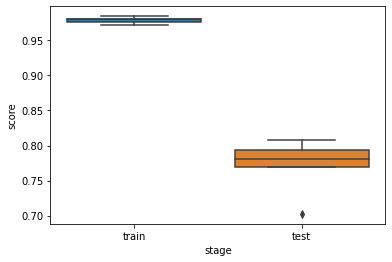

In [21]:
sns.boxplot(data = scores_df, x = 'stage', y = 'score')

In [22]:
FinalModel = MyMultiTrainTester.TrainerList[0]

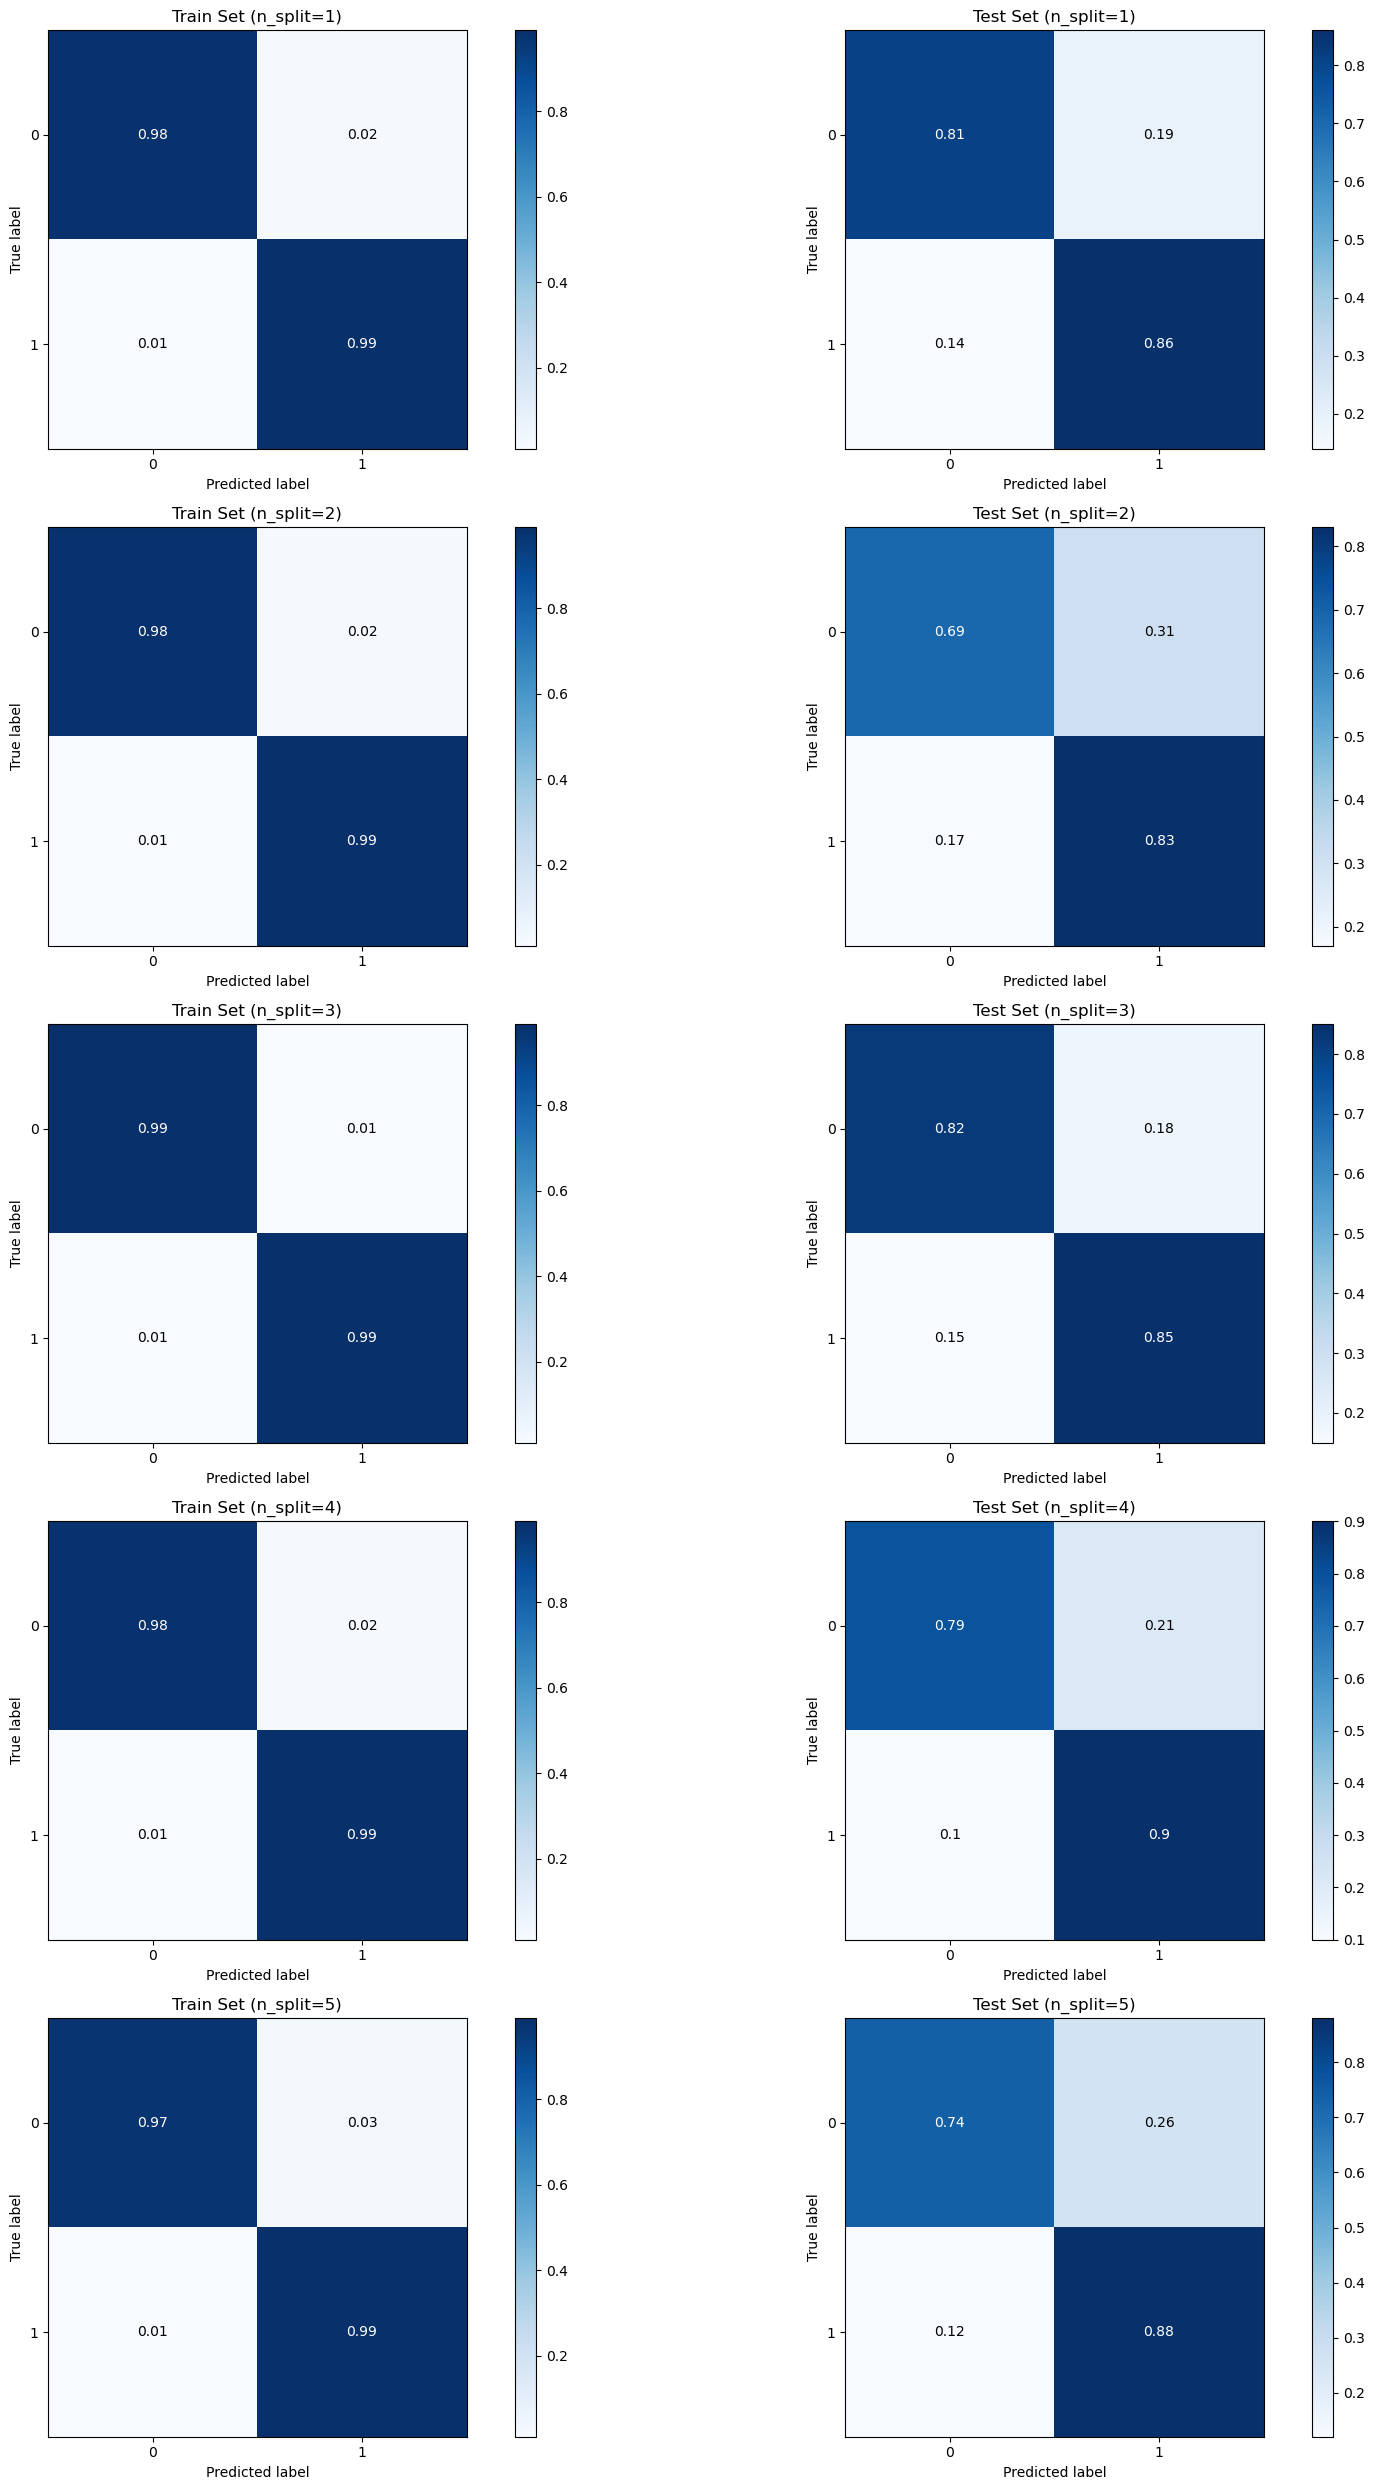

In [23]:
MyMultiTrainTester.plot_confusion(normalize=True)

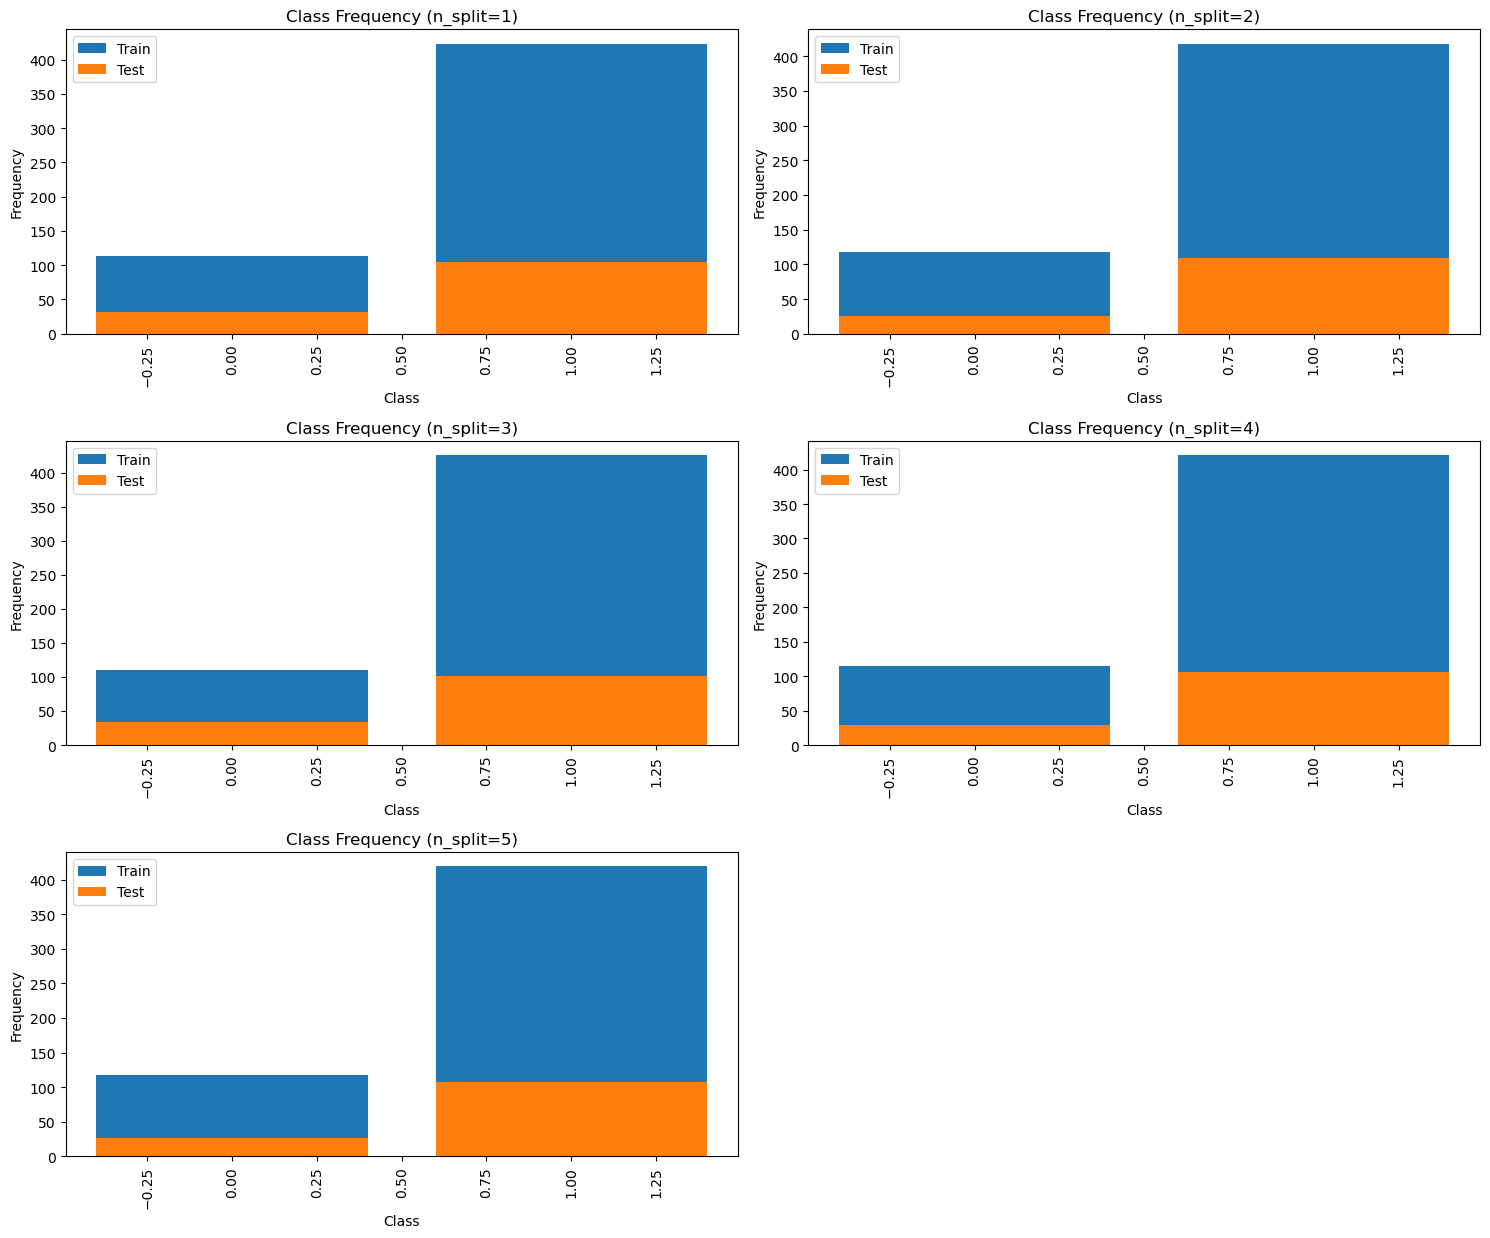

In [24]:
MyMultiTrainTester.plot_class_freq(normalize=True)

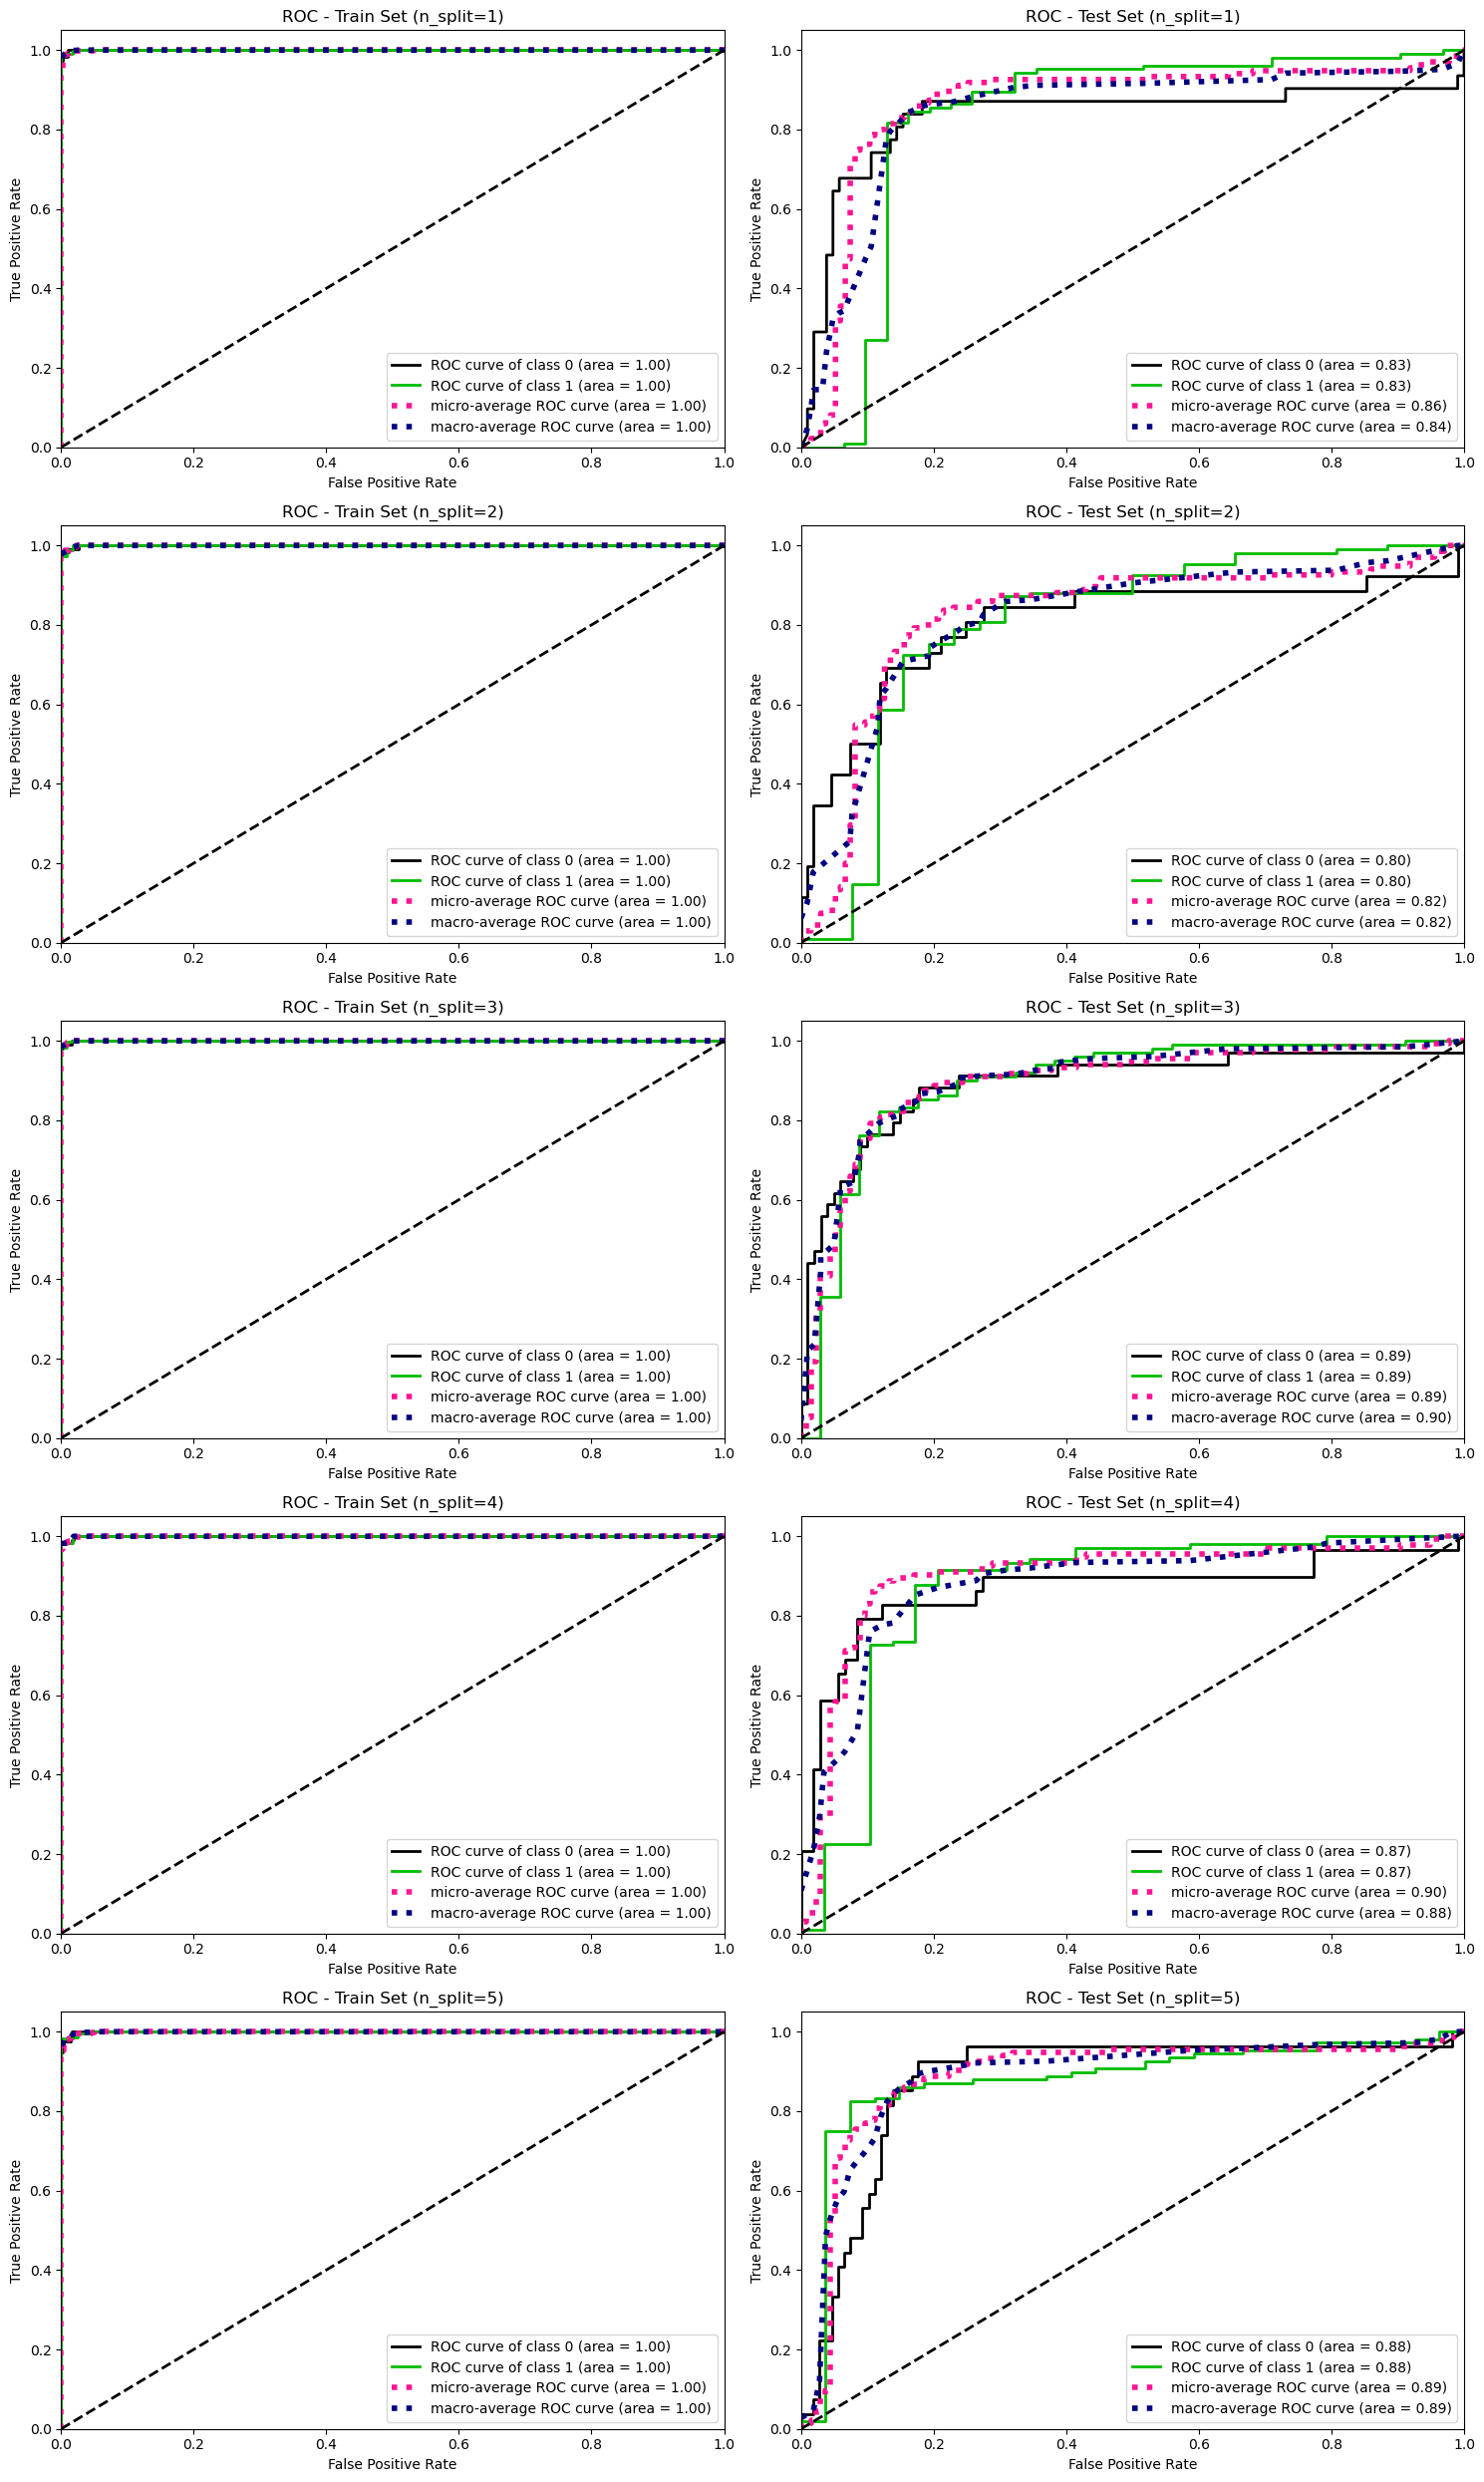

In [25]:
MyMultiTrainTester.plot_roc()

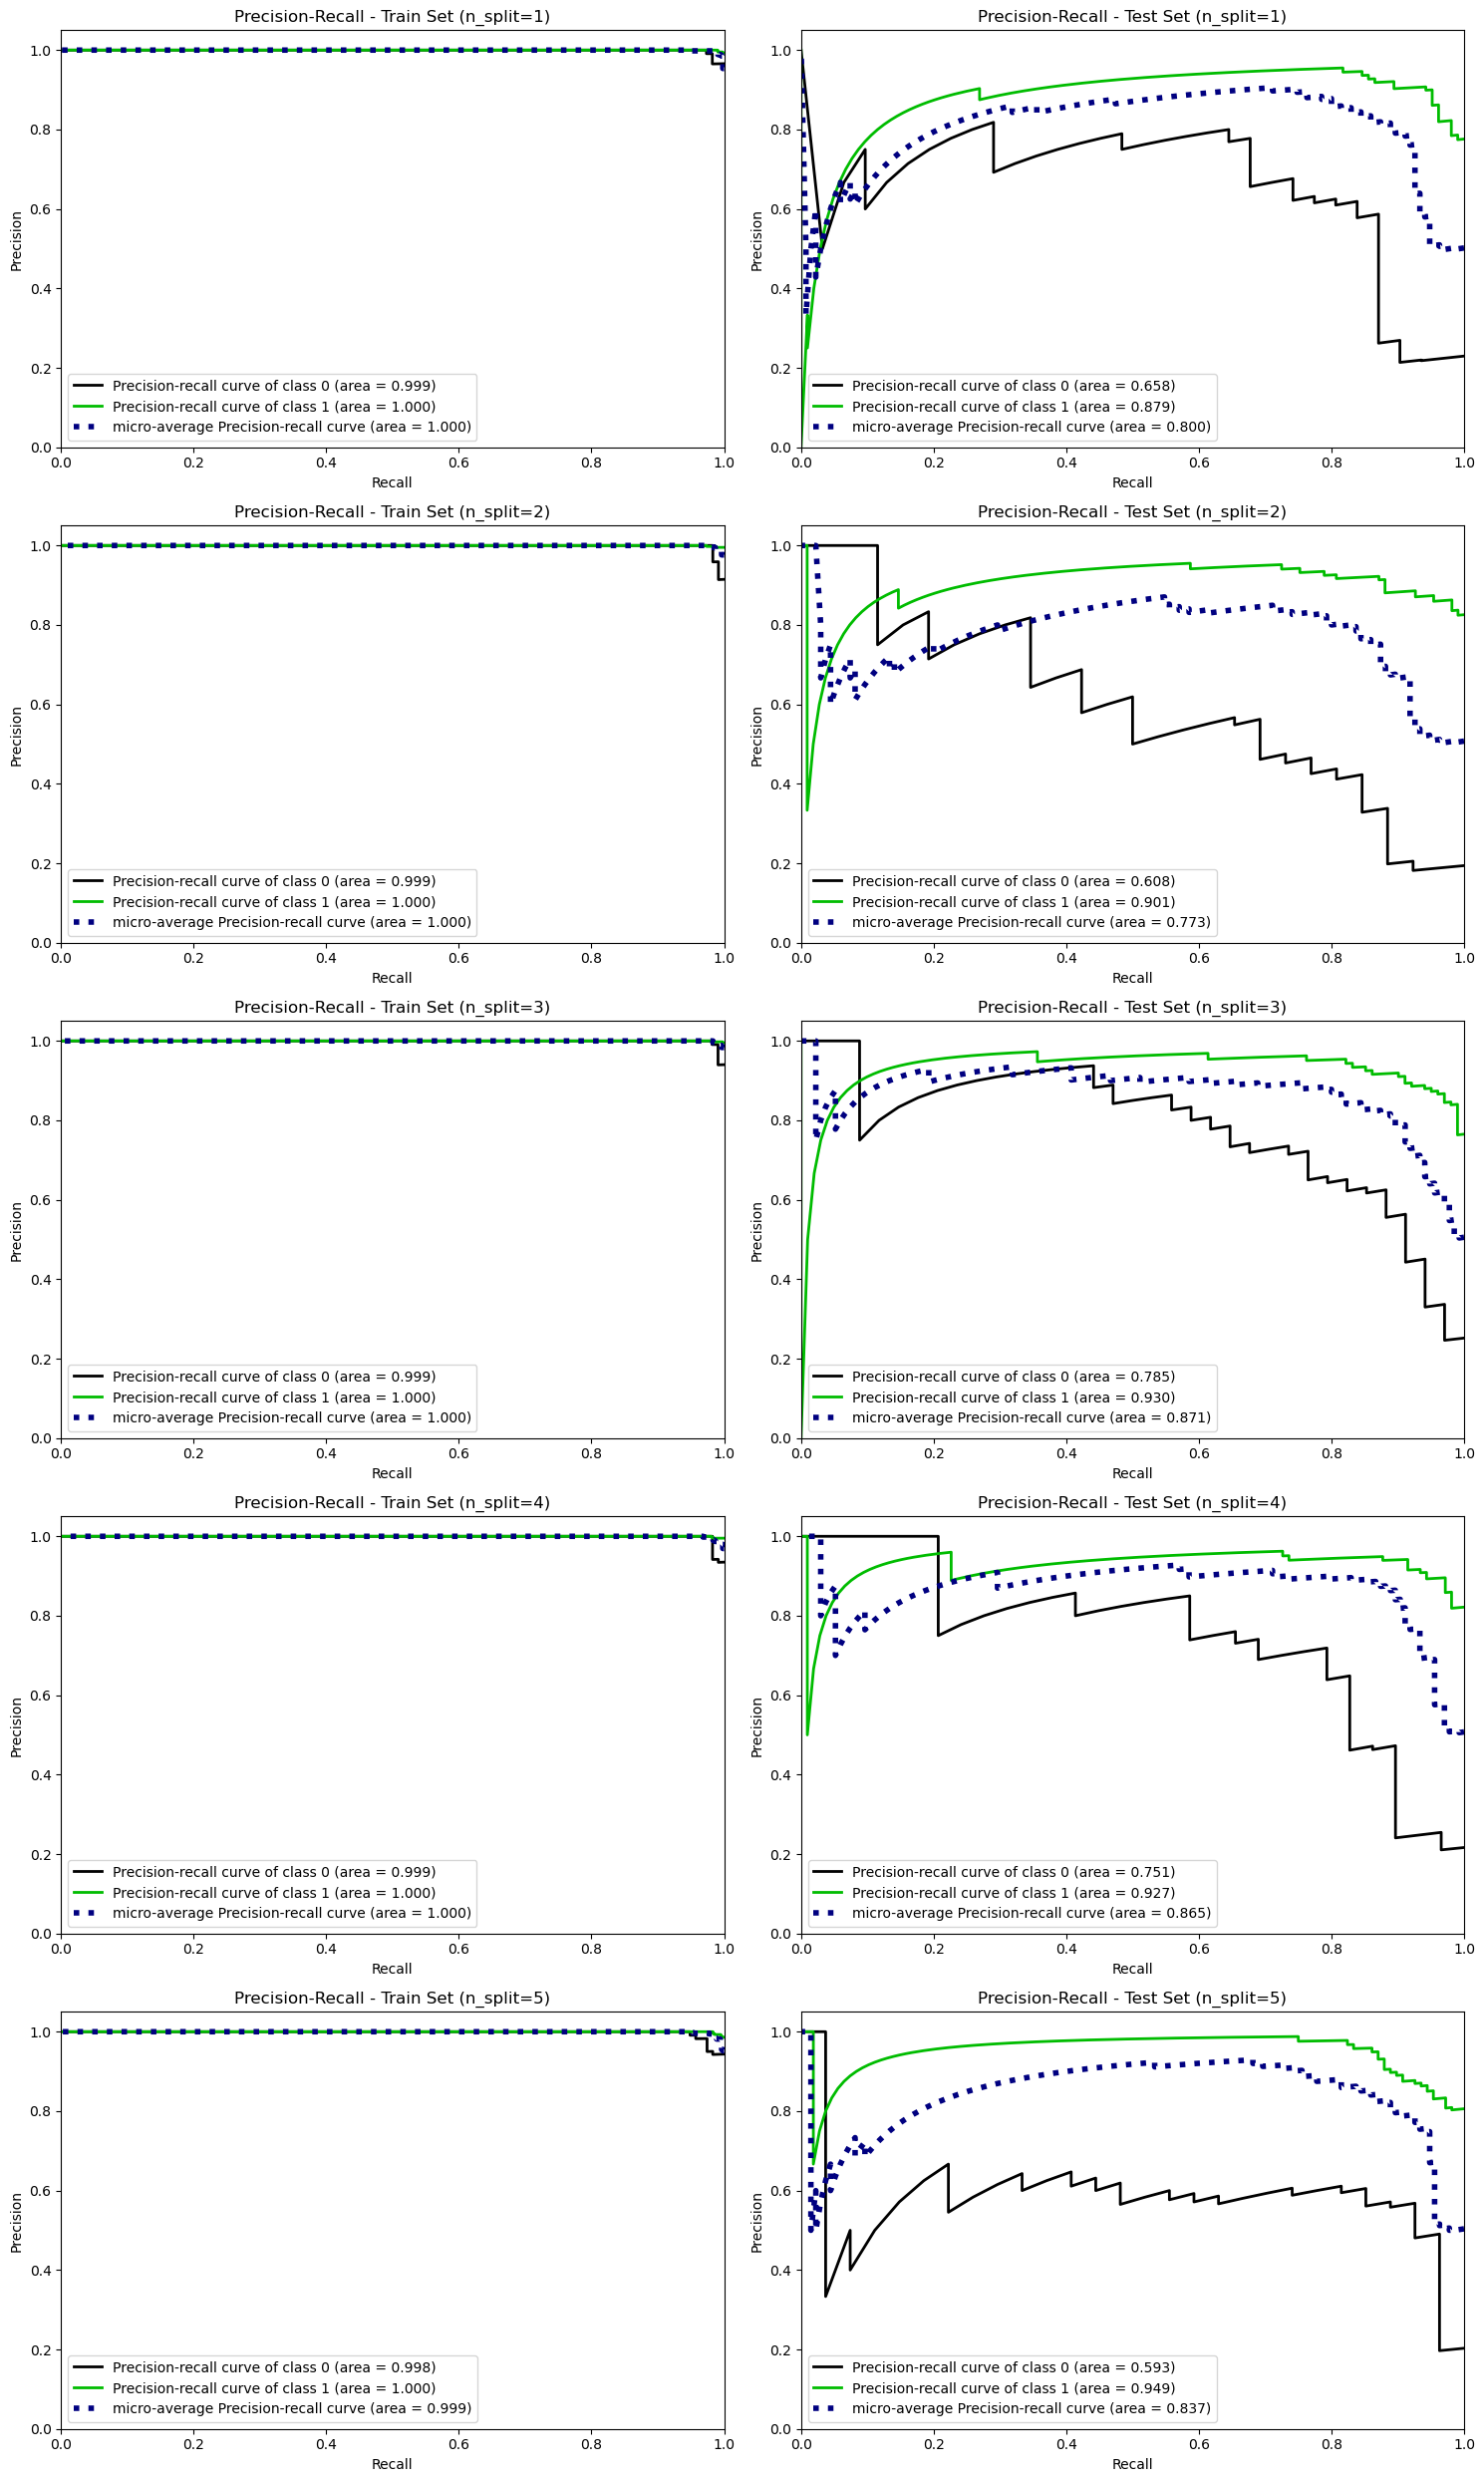

In [26]:
MyMultiTrainTester.plot_precrecall()

# Evaluate Model Performance on ACVD Study Data Only

In [27]:
SampleMeta.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'study',
       'Study No. (From VG sheet (V-*) from SB sheet (S-*))', 'Title of Paper',
       'Author (year)', 'Journal', 'Study Accession',
       'Sample Accession or Sample ID', 'Sample title (ENA/SRA)',
       'Sample title (Paper)', 'Subject Id (If available)', 'Age (Years)',
       'BMI', 'Gender', 'GRoP', 'Phenotype', 'FBG', 'TRIG', 'LDLC', 'CHOL',
       'HDLC', 'Phys_Ex', 'Smoking', 'Residence', 'milk', 'meat', 'alcohol',
       'Diet1', 'Diet2', 'medication', 'Sequencing Platform',
       'Library layout (SINGLE/PAIRED)', 'Read count after Quality control',
       'Healthy', 'age_group', 'age_category'],
      dtype='object')

In [28]:
train_idx0 = MyMultiTrainTester.train_idx[0]
test_idx0 = MyMultiTrainTester.test_idx[0]
SampleMetaTrain = SampleMeta.iloc[train_idx0, :]
SampleMetaTest = SampleMeta.iloc[test_idx0, :]

In [29]:
# get indices
train_idx_study = np.argwhere((SampleMetaTrain['Study Accession'] == 'PRJEB21528').to_numpy()).flatten()
test_idx_study = np.argwhere((SampleMetaTest['Study Accession'] == 'PRJEB21528').to_numpy()).flatten()

In [30]:
# check metadata
SampleMetaTrain.iloc[train_idx_study, :]['Gender'].value_counts()

M    109
F     58
Name: Gender, dtype: int64

In [31]:
SampleMetaTest.iloc[test_idx_study, :]['Gender'].value_counts()

M    34
F    18
Name: Gender, dtype: int64

In [32]:
np.sum(SampleMetaTrain.iloc[train_idx_study, :]['BMI'].to_numpy() == -99)

0

In [33]:
np.sum(SampleMetaTest.iloc[test_idx_study, :]['BMI'].to_numpy() == -99)

0

In [34]:
# Setup data for evaluation
X_train_study = X[train_idx0, :][train_idx_study, :]
y_train_study = y[train_idx0][train_idx_study]
X_test_study = X[test_idx0, :][test_idx_study, :]
y_test_study = y[test_idx0][test_idx_study]

## Train

In [35]:
FinalModel.score(X_train_study, y_train_study, RECALL_SCORE)

0.9726319239593575

In [36]:
X_train_study_transf = FinalModel.transform_X(X_train_study)

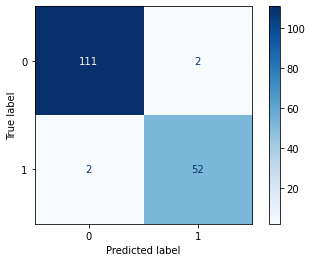

In [37]:
metrics.plot_confusion_matrix(FinalModel.model, X_train_study_transf, y_train_study, cmap=plt.cm.Blues)

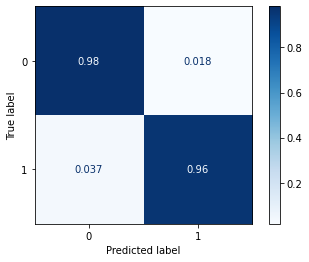

In [38]:
metrics.plot_confusion_matrix(FinalModel.model, X_train_study_transf, y_train_study, normalize='true', cmap=plt.cm.Blues)

## Test

In [39]:
FinalModel.score(X_test_study, y_test_study, RECALL_SCORE)

0.8214285714285714

In [40]:
X_test_study_transf = FinalModel.transform_X(X_test_study)

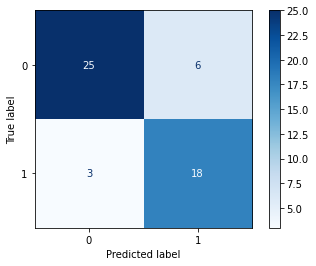

In [41]:
# test confusion matrix using only data from study with ACVD stuff
metrics.plot_confusion_matrix(FinalModel.model, X_test_study_transf, y_test_study, cmap=plt.cm.Blues)

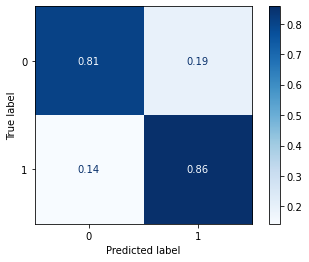

In [42]:
metrics.plot_confusion_matrix(FinalModel.model, X_test_study_transf, y_test_study, normalize='true', cmap=plt.cm.Blues)